# Construction monitoring

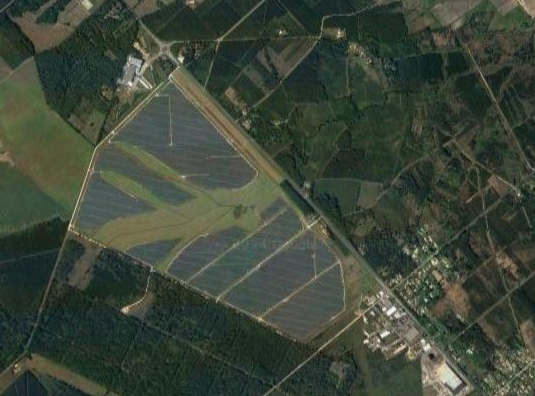

In this notebook, we will explore the construction of a solar power plant in France. The main goal of this exercise is to manipulate satellite data and determine the start date of the construction.

A stack of Sentinel-2 data from 2016 to 2024 is available in Zarr format.

To manipulate the Zarr data structure, you can use:
`xarray.open_zarr`. This function returns an xarray Dataset object.

In [27]:
import xarray as xr

zarr_file_path = "zarr_file"
ds = xr.open_zarr(zarr_file_path)

In [28]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [29]:
print(ds)

<xarray.Dataset>
Dimensions:    (time: 1030, latitude: 108, longitude: 98)
Coordinates:
  * latitude   (latitude) float64 48.66 48.66 48.66 48.66 ... 48.65 48.65 48.65
  * longitude  (longitude) float64 2.18 2.18 2.18 2.181 ... 2.193 2.193 2.193
  * time       (time) datetime64[ns] 2016-11-07T10:52:00 ... 2024-05-29T10:57:00
Data variables: (12/13)
    band_0     (time, latitude, longitude) float32 dask.array<chunksize=(258, 27, 25), meta=np.ndarray>
    band_1     (time, latitude, longitude) float32 dask.array<chunksize=(258, 27, 25), meta=np.ndarray>
    band_10    (time, latitude, longitude) float32 dask.array<chunksize=(258, 27, 25), meta=np.ndarray>
    band_11    (time, latitude, longitude) float32 dask.array<chunksize=(258, 27, 25), meta=np.ndarray>
    band_12    (time, latitude, longitude) float32 dask.array<chunksize=(258, 27, 25), meta=np.ndarray>
    band_2     (time, latitude, longitude) float32 dask.array<chunksize=(258, 27, 25), meta=np.ndarray>
    ...         ...
    b

The bands mapping the xarray dataset is not the correct one : using this dictionnary, remap data variables name ?
``` 
m = {"band_0":"band_1",
"band_1":"band_2",
"band_2":"band_3",
"band_3":"band_4",
"band_4":"band_5",
"band_5":"band_6",
"band_6":"band_7",
"band_7":"band_8",
"band_8":"band_8A",
"band_9":"band_9",
"band_10":"band_11",
"band_11":"band_12",
"band_12":"dataMask"}
```

In [30]:
m = {"band_0":"band_1",
"band_1":"band_2",
"band_2":"band_3",
"band_3":"band_4",
"band_4":"band_5",
"band_5":"band_6",
"band_6":"band_7",
"band_7":"band_8",
"band_8":"band_8A",
"band_9":"band_9",
"band_10":"band_11",
"band_11":"band_12",
"band_12":"dataMask"}

ds = ds.rename(m)



In [31]:
names = list(ds.data_vars.keys())
print(names)


['band_1', 'band_2', 'band_11', 'band_12', 'dataMask', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7', 'band_8', 'band_8A', 'band_9']


Using xarray function determine the start date and the end date of the image stack ? 

In [32]:
start = ds.time.min().values
end = ds.time.max().values

print(f"Start Date: {start}")
print(f"End Date: {end}")


Start Date: 2016-11-07T10:52:00.000000000
End Date: 2024-05-29T10:57:00.000000000


### Plot series

For the band_3 (from the new mapping) compute the average value of this data variable by image. Then plot the resulted time series. Check the documentation here : https://docs.xarray.dev/en/latest/user-guide/plotting.html

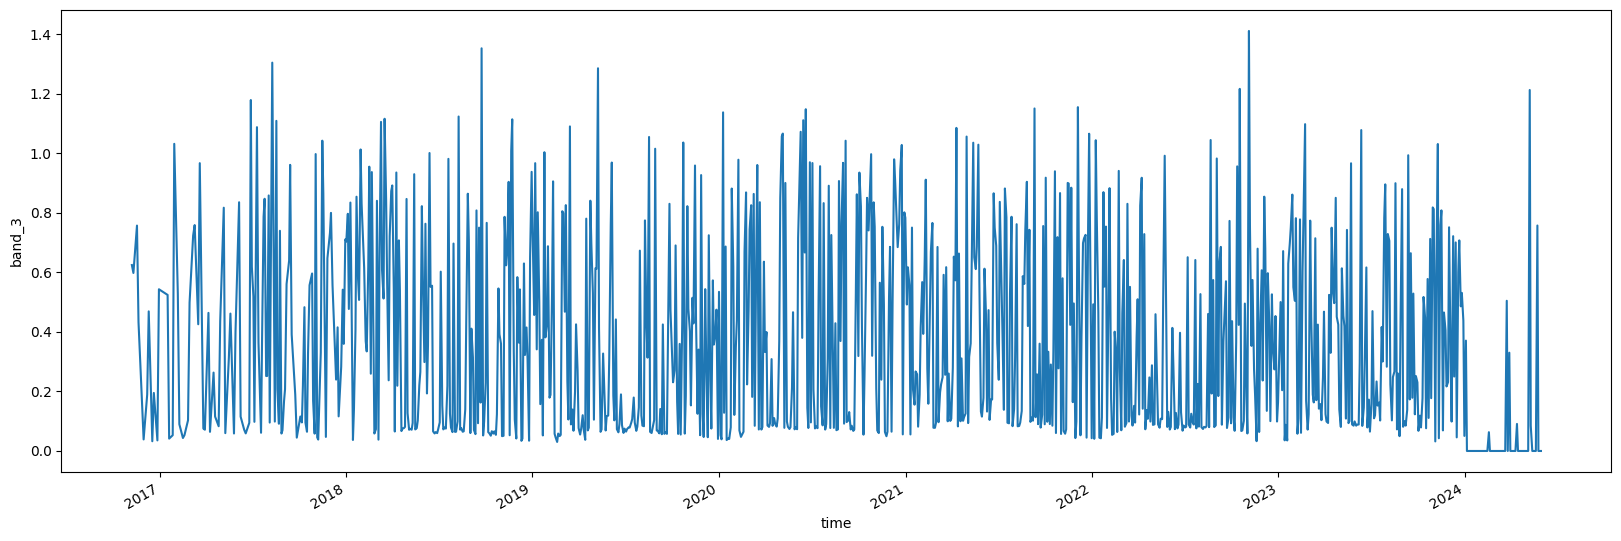

In [33]:
import matplotlib.pyplot as plt

b3 = ds["band_3"]

avg_band3 = b3.mean(dim=["latitude", "longitude"])

avg_band3.plot(figsize=(20, 6))

What can you conclude ? 

The data is too noisy.

## Cloud detection

The provided image stack doesn't contains any cloud filtering. All image take from 2016 by Sentinel 2 are available. 
Then we will create a cloud detection algorithm. 
The Braaten-Cohen-Yang algorithm is a very simple cloud detector based on sentinel 2 bands.

$ NDGR = \frac{B3 - B4}{B3 + B4}$   
$ Cloud = (B3 > 0.175 \wedge NDGR > 0) \vee (B3 > 0.39) $

$Cloud = 1$ mean the presence of a cloud for the considered pixel. 0 otherwise
 

Using this formula :
- Create the NDGR data variable
- Create the Cloud data variable


In [34]:
b3 = ds["band_3"]
b4 = ds["band_4"]
ndgr = (b3 - b4)/(b3+b4)

cloud = ((b3 > 0.175) & (ndgr > 0)) | (b3 > 0.39)

print(ndgr.shape)

(1030, 108, 98)


Filter the xarray to keep the image where the percentage of cloud in the image is bellow 20%  
Tips : use `.sel()` function to filter the DataSet

In [35]:
cloud_sum = cloud.sum(dim=["latitude", "longitude"]) 

cloud_pourcentage = cloud_sum/(108*98)*100

filtered_ds = ds.sel(time = ds["time"].values[cloud_pourcentage < 20])

Plot the band_3 average time series :

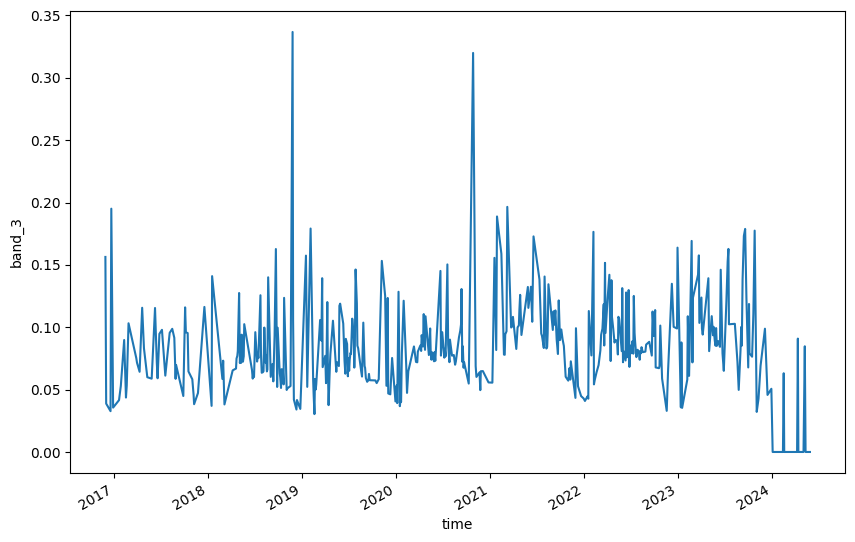

In [36]:
b3 = filtered_ds["band_3"]

# Calculer la moyenne par image (moyenne sur latitude et longitude)
avg_band3 = b3.mean(dim=["latitude", "longitude"])

# Tracer la série temporelle
avg_band3.plot(figsize=(10, 6))

## Create the NDVI index

The normalized difference vegetation index (NDVI) is a widely-used metric for quantifying the health and density of vegetation using sensor data. It is calculated from spectrometric data at two specific bands: red and near-infrared. The spectrometric data is usually sourced from remote sensors, such as satellites.  

$NDVI = \frac{B8 - B4}{B8 + B4}$



During construction, the amount of vegetation on the site decreases significantly. This reduction should also be reflected in the NDVI index.

Create the NDVI data variable and plot the average NDVI by image in a time series

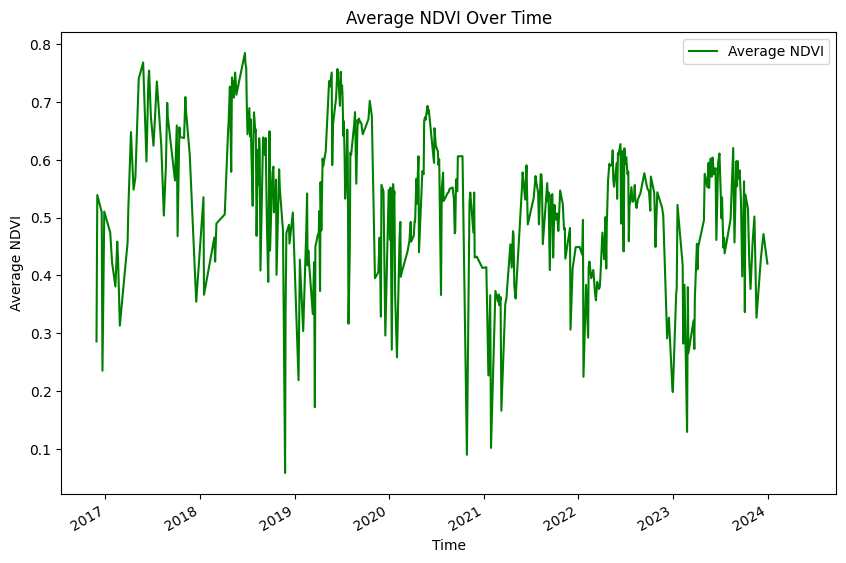

In [37]:
b8 = filtered_ds["band_8"]
b4 = filtered_ds["band_4"]
ndvi = (b8-b4)/(b8+b4)

avg_ndvi = ndvi.mean(dim=["latitude", "longitude"])

# Tracer la série temporelle du NDVI moyen
plt.figure(figsize=(10, 6))
avg_ndvi.plot(label="Average NDVI", color="green")
plt.xlabel('Time')
plt.ylabel('Average NDVI')
plt.title('Average NDVI Over Time')
plt.legend()
plt.show()

## Work on seasonality

As you may see, the given NDVI index is very seasonal due to the seasonality of vegetation growth.  
In the following step we will work on the seasonality removal and change detection. 

Using `statsmodels.tsa.seasonal` extract the trend, the seasonal signal and the noise of the NDVI time series.  
Plot these 3 componants.  

In [38]:
print(ndvi.shape)
print(ds.band_8.shape)
print(ds.band_4.shape)
images_2018 = ndvi.sel(time=ndvi.time.dt.year == 2018)
print(len(images_2018.time))
images_2018 = ndvi.sel(time=ndvi.time.dt.year == 2019)
print(len(images_2018.time))
images_2018 = avg_ndvi.sel(time=avg_ndvi.time.dt.year == 2020)
print(len(images_2018.time))



(470, 108, 98)
(1030, 108, 98)
(1030, 108, 98)
62
68
63


In [39]:
print(avg_ndvi)

<xarray.DataArray (time: 470)>
dask.array<mean_agg-aggregate, shape=(470,), dtype=float32, chunksize=(129,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-11-27T10:54:00 ... 2024-05-29T10:57:00


In [40]:
avg_ndvi.to_pandas().resample("D").ffill().bfill()


time
2016-11-27    0.285781
2016-11-28    0.285781
2016-11-29    0.285781
2016-11-30    0.285781
2016-12-01    0.538874
                ...   
2024-05-25         NaN
2024-05-26         NaN
2024-05-27         NaN
2024-05-28         NaN
2024-05-29         NaN
Freq: D, Length: 2741, dtype: float32

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

ndvi_clean = avg_ndvi.to_pandas().dropna().resample("D").ffill().bfill()
print(ndvi_clean.values)
decomposition = seasonal_decompose(ndvi_clean, period=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

[0.28578123 0.28578123 0.28578123 ... 0.54276645 0.54276645 0.54276645]


In [42]:
print(trend.dropna())

time
2017-05-28    0.569538
2017-05-29    0.570421
2017-05-30    0.571304
2017-05-31    0.572187
2017-06-01    0.573070
                ...   
2023-11-05    0.477028
2023-11-06    0.476938
2023-11-07    0.476848
2023-11-08    0.476758
2023-11-09    0.476669
Freq: D, Name: trend, Length: 2357, dtype: float64


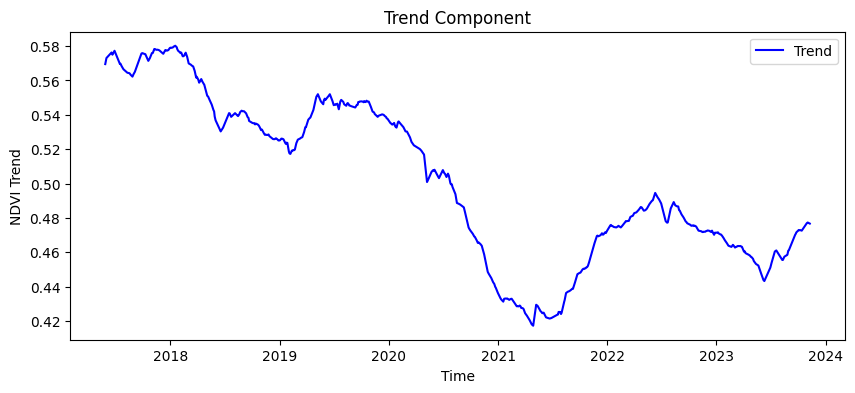

In [43]:
plt.figure(figsize=(10, 4))
plt.plot(trend.dropna(), label="Trend", color="blue")
plt.xlabel("Time")
plt.ylabel("NDVI Trend")
plt.title("Trend Component")
plt.legend()
plt.show()

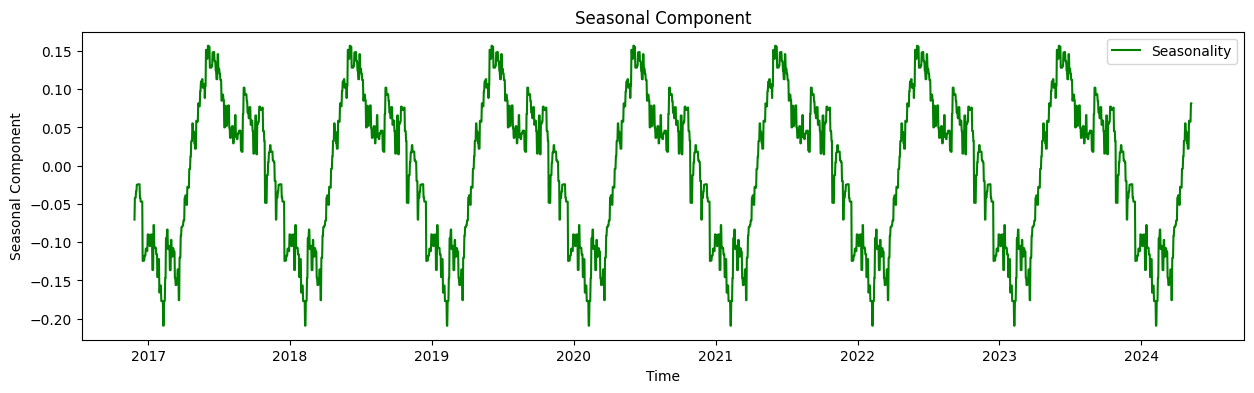

In [44]:
plt.figure(figsize=(15, 4))
plt.plot(seasonal, label="Seasonality", color="green")
plt.xlabel("Time")
plt.ylabel("Seasonal Component")
plt.title("Seasonal Component")
plt.legend()
plt.show()

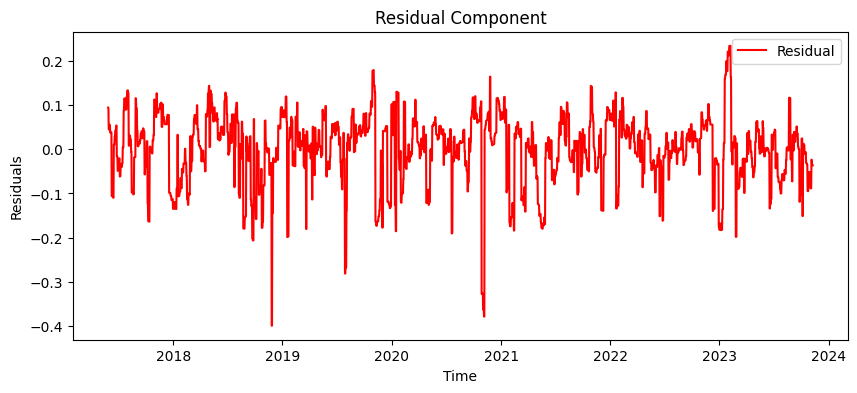

In [45]:
plt.figure(figsize=(10, 4))
plt.plot(residual, label="Residual", color="red")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Residual Component")
plt.legend()
plt.show()

Visually, what can you conclude ? 

# Conlusion
We can conclude that the construction began in the first half of 2019 and ended in early 2021 !